In [1]:
## for data
import numpy as np
import pandas as pd

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for geospatial
import folium
import geopy

## for machine learning
from sklearn import preprocessing, cluster
import scipy


In [2]:
dtf = pd.read_csv('https://raw.githubusercontent.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/master/machine_learning/data_stores.csv')
dtf.columns.tolist()

['Brand',
 'Store Number',
 'Store Name',
 'Ownership Type',
 'Street Address',
 'City',
 'State/Province',
 'Country',
 'Postcode',
 'Phone Number',
 'Timezone',
 'Longitude',
 'Latitude']

In [3]:
dtf.to_csv('./bahan/data_stores.csv')

Dataset asli berisi lebih dari 5.000 kota dan 25.000 toko, tetapi untuk tujuan study case ini, Kita akan bekerja hanya dengan satu kota.

In [4]:
filter = "Las Vegas"
dtf = dtf[dtf["City"]==filter][["City","Street Address","Longitude","Latitude"]].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={"index":"id"})
dtf.head()

,id,City,Street Address,Longitude,Latitude
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11


In [5]:
dtf.nunique()

id                156
City                1
Street Address    140
Longitude          26
Latitude           28
dtype: int64

Di kawasan itu, ada 156 toko. Untuk melanjutkan kasus bisnis, kita akan mensimulasikan beberapa informasi untuk setiap toko:

- Potensi: total kapasitas dalam hal staf (misalnya 10 berarti toko dapat memiliki hingga 10 karyawan)
- Staf: tingkat staf saat ini (misalnya 7 berarti toko saat ini beroperasi dengan 7 karyawan)
- Kapasitas: kapasitas kiri saat ini (misalnya 10–7=3, toko masih dapat menampung 3 karyawan)
- Biaya: biaya tahunan bagi perusahaan untuk menjaga agar toko tetap beroperasi (“rendah”, “sedang”, “tinggi”)

In [6]:
dtf["Potential"] = np.random.randint(low=3, high=10+1, size=len(dtf))
dtf["Staff"] = dtf["Potential"].apply(lambda x: int(np.random.rand()*x)+1)
dtf["Capacity"] = dtf["Potential"] - dtf["Staff"]
dtf["Cost"] = np.random.choice(["high","medium","low"], size=len(dtf), p=[0.4,0.5,0.1])
dtf.head()


,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12,7,6,1,medium
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04,9,6,3,medium
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13,9,6,3,high
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22,3,2,1,medium
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11,3,1,2,medium


Harap dicatat bahwa ini hanya simulasi, angka-angka ini dihasilkan secara acak dan tidak benar-benar mencerminkan bisnis Starbucks (atau perusahaan lain mana pun).

Sekarang semuanya sudah siap, kita akan mulai dengan menganalisis kasus bisnis, kemudian membangun model pengelompokan dan algoritma rasionalisasi.

Mari kita mulai, ya?

# EDA

Anggap saja kita memiliki bisnis ritel dan kita harus menutup beberapa toko. Kita ingin melakukan itu dengan memaksimalkan keuntungan (dengan meminimalkan biaya) dan tanpa memberhentikan staf.

Biaya didistribusikan sebagai berikut:

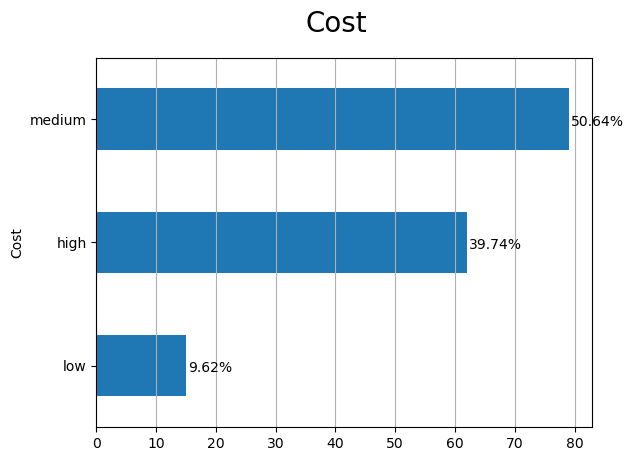

In [7]:
x = "Cost"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()


In [9]:
print(ax.patches)

<Axes.ArtistList of 10 patches>


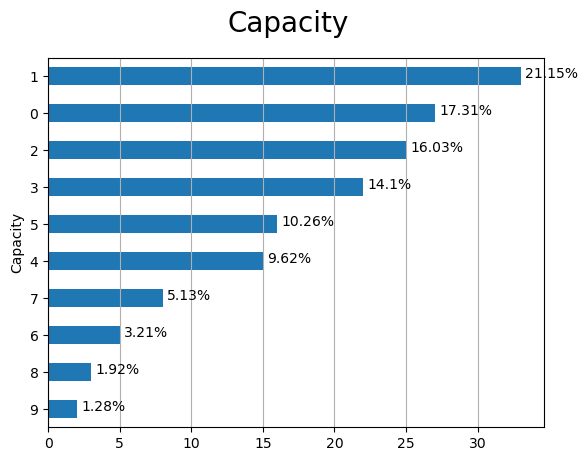

In [8]:
x = "Capacity"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()


Saat ini, hanya sebagian kecil toko yang beroperasi dengan potensi penuh (Kapasitas kiri = 0), artinya ada beberapa dengan staf yang sangat rendah (Kapasitas kiri tinggi):

Mari kita visualisasikan potongan-potongan informasi itu di peta. Pertama-tama, Kita perlu mendapatkan koordinat area geografis untuk memulai peta. Kita akan melakukannya dengan geopy:

In [10]:
city = "Las Vegas"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Las Vegas, 4, Clark County, Nevada, United States
[lat, long]: [36.1674263, -115.1484131]


Kita akan membuat peta dengan folium, package yang sangat nyaman yang memungkinkan kita untuk memplot peta interaktif tanpa perlu memuat shapefile. Setiap toko harus diidentifikasi dengan titik dengan ukuran proporsional dengan staf saat ini dan warna berdasarkan biayanya. Kita juga akan menambahkan sepotong kecil kode HTML ke peta default untuk menampilkan legenda.

In [11]:
x, y = "Latitude", "Longitude"
color = "Cost"
size = "Staff"
popup = "Street Address"
data = dtf.copy()

## create color column
lst_colors=["red","green","orange"]
lst_elements = sorted(list(dtf[color].unique()))
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)

## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

## plot the map
map_

Tujuan kita adalah untuk menutup sebanyak mungkin toko berbiaya tinggi (titik merah) dengan memindahkan staf mereka ke toko berbiaya rendah (titik hijau) dengan kapasitas yang terletak di lingkungan yang sama. Akibatnya, kita akan memaksimalkan keuntungan (dengan menutup toko berbiaya tinggi) dan efisiensi (dengan memiliki toko berbiaya rendah yang bekerja dengan kapasitas penuh).

Bagaimana kita bisa mendefinisikan lingkungan tanpa memilih ambang jarak dan batas geografis? Nah, jawabannya adalah… Clustering.

# Model Building : Clustering and Evaluation

Di sini, untuk menentukan k yang tepat, Kita akan menggunakan Metode Siku: memplot varians sebagai fungsi dari jumlah cluster dan memilih k yang meratakan kurva.

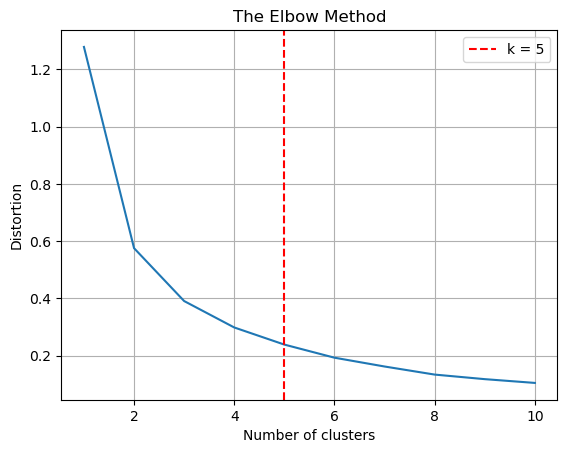

In [13]:
X = dtf[["Latitude","Longitude"]]
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

Kita dapat mencoba dengan k = 5 sehingga algoritma K-Means akan menemukan 5 centroid teoritis. Selain itu, Kita juga akan mengidentifikasi centroid sebenarnya (pengamatan terdekat dengan pusat cluster).

In [14]:
k = 5
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = dtf[["Latitude","Longitude"]]
## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
dtf.sample(5)

/tmp/ipykernel_10347/3237973723.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dtf_X["centroids"].iloc[i] = 1
/tmp/ipykernel_10347/3237973723.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost,cluster,centroids
53,53,Las Vegas,"3333 Blue Diamond Road, Tule Springs Village",-115.18,36.04,9,9,0,medium,2,0
131,131,Las Vegas,5757 Paradise Road,-115.14,36.08,9,6,3,medium,2,0
34,34,Las Vegas,2411 West Sahara Ave,-115.18,36.14,7,5,2,high,2,0
20,20,Las Vegas,8540 W Desert Inn Rd,-115.28,36.13,10,3,7,high,1,0
144,144,Las Vegas,"7101 West Craig Road, 1",-115.25,36.24,5,2,3,medium,3,0


Kita menambahkan dua kolom ke dataset: "cluster" yang menunjukkan cluster apa yang menjadi milik observasi, dan "centroids" yaitu 1 jika pengamatan juga merupakan centroid (paling dekat dengan pusat) dan 0 sebaliknya. Mari kita rencanakan:

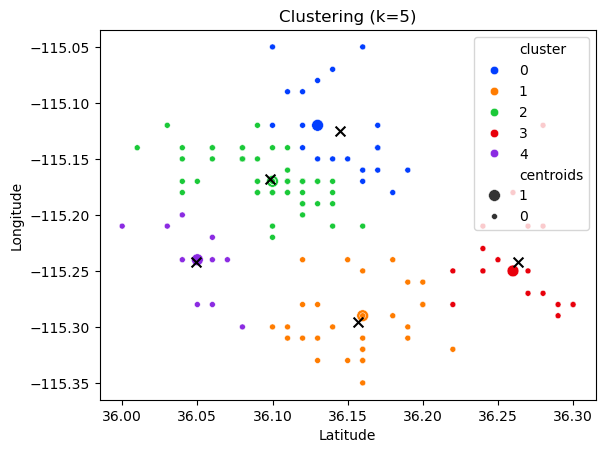

In [15]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="Latitude", y="Longitude", data=dtf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

Terlepas dari algoritma yang Anda gunakan untuk mengelompokkan data, sekarang Anda memiliki kumpulan data dengan dua kolom lagi (“cluster”, “centroids”). Kita dapat menggunakannya untuk memvisualisasikan cluster pada peta, dan kali ini kita akan menampilkan centroid juga menggunakan marker.

In [16]:
x, y = "Latitude", "Longitude"
color = "cluster"
size = "Staff"
popup = "Street Address"
marker = "centroids"
data = dtf.copy()
## create color column
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
## add centroids marker
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           popup=row[marker], draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
## plot the map
map_

Sekarang kita memiliki cluster, kita dapat memulai rasionalisasi toko di dalam masing-masing cluster.

# Store Rationalization

Karena fokus utama artikel ini adalah mengelompokkan data geospasial, Kita akan membuat bagian ini tetap sederhana. Di dalam setiap cluster, Kita akan memilih target potensial (toko berbiaya tinggi) dan hub (toko berbiaya rendah), dan merelokasi staf target di hub sampai yang terakhir mencapai kapasitas penuh. Ketika seluruh staf target dipindahkan, toko bisa ditutup.

In [18]:
dtf_new = pd.DataFrame()
for c in sorted(dtf["cluster"].unique()):
    dtf_cluster = dtf[dtf["cluster"] == c]

    # hubs and targets
    lst_hubs = dtf_cluster[dtf_cluster["Cost"] == "low"
                           ].sort_values("Capacity").to_dict("records")
    lst_targets = dtf_cluster[dtf_cluster["Cost"] == "high"
                              ].sort_values("Staff").to_dict("records")
    # move targets
    for target in lst_targets:
        for hub in lst_hubs:
            # if hub has space
            if hub["Capacity"] > 0:
                residuals = hub["Capacity"] - target["Staff"]
                # case of hub has still capacity: do next target
                if residuals >= 0:
                    hub["Staff"] += target["Staff"]
                    hub["Capacity"] = hub["Potential"] - hub["Staff"]
                    target["Capacity"] = target["Potential"]
                    target["Staff"] = 0
                    break
                # case of hub is full: do next hub
                else:
                    hub["Capacity"] = 0
                    hub["Staff"] = hub["Potential"]
                    target["Staff"] = -residuals
                    target["Capacity"] = target["Potential"] - target["Staff"]
dtf_new = pd.concat([dtf_new, pd.DataFrame(lst_hubs)], ignore_index=True)
dtf_new = pd.concat([dtf_new, pd.DataFrame(lst_targets)], ignore_index=True)
dtf_new = pd.concat([dtf_new, dtf[dtf["Cost"] == "medium"]], ignore_index=True)

dtf_new = dtf_new.sort_values(["cluster", "Staff"]).reset_index(drop=True)

dtf_new.head()

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost,cluster,centroids
0,61,Las Vegas,"2585 S. Nellis Blvd., #1",-115.07,36.14,6,1,5,medium,0,0
1,96,Las Vegas,1925 N. Martin Luther King Blvd.,-115.16,36.19,3,1,2,medium,0,0
2,135,Las Vegas,"2412 E. Desert Inn Road, #100",-115.12,36.13,4,1,3,medium,0,1
3,38,Las Vegas,"751 N. Rancho Drive, #110",-115.18,36.18,4,2,2,medium,0,0
4,102,Las Vegas,"3805 E. Flamingo Road, #100",-115.09,36.11,7,2,5,medium,0,0


In [21]:
dtf_cluster.shape

(11, 11)

Ini adalah algoritma yang sangat sederhana yang dapat ditingkatkan dalam beberapa cara: misalnya, dengan memasukkan toko-toko berbiaya menengah ke dalam persamaan dan meniru prosesnya ketika toko-toko berbiaya rendah semuanya penuh.

Mari kita lihat berapa banyak toko mahal yang kita tutup dengan proses dasar ini:

In [19]:
dtf_new["closed"] = dtf_new["Staff"].apply(lambda x: 1 
                                           if x==0 else 0)
print("closed:", dtf_new["closed"].sum())

closed: 0


In [20]:
x, y = "Latitude", "Longitude"
color = "cluster"
size = "Staff"
popup = "Street Address"
marker = "centroids"
data = dtf_new.copy()
## create color column
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
## add centroids marker
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           popup=row[marker], draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
## plot the map
map_